Необходимо сформировать модель монетизации игрового приложения. Основная монетизация игры — только планируется. Но предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

В датасете представлены данные по игре пользователей на первом уровне. Завершение первого уровня требует от игрока выполнения одного из двух условий:

- Победа над первым врагом
- Реализация проекта - разработка орбитальной сборки спутников

План проекта:

1) Предобработка данных

2) Исследовательский анализ данных

3) Создание модели монетизации

4) Выдвижение и проверка гипотез

## Предобработка данных

In [1]:
import pandas as pd
from datetime import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

game_actions = pd.read_csv('/datasets/game_actions.csv')
ad_costs = pd.read_csv('/datasets/ad_costs.csv')
user_source = pd.read_csv('/datasets/user_source.csv')


In [2]:
game_actions

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN
...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN


In [3]:
#проверим типы данных и количество пропущенных значений
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
event_datetime    135640 non-null object
event             135640 non-null object
building_type     127957 non-null object
user_id           135640 non-null object
project_type      1866 non-null object
dtypes: object(5)
memory usage: 5.2+ MB


*Пропущенные значения в столбце building_type оставим как есть, поскольку это означает, что игрок еще не начинал стройку какого-либо здания. Пустые значения в project_type означают, что игроки прошли уровень способом уничтожения противника. Пустые значения в столбце project_type будут заменены позже при распределении пользователей на группы*

In [4]:
#изменим тип в столбце event_datetime и выведем составные части даты и времени
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
game_actions['time'] = game_actions['event_datetime'].dt.time
game_actions['month'] = game_actions['event_datetime'].dt.month
game_actions['day'] = game_actions['event_datetime'].dt.day
game_actions['hour'] = game_actions['event_datetime'].dt.hour
game_actions['minute'] = game_actions['event_datetime'].dt.minute
game_actions['second'] = game_actions['event_datetime'].dt.second
game_actions

,event_datetime,event,building_type,user_id,project_type,time,month,day,hour,minute,second
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:00:01,5,4,0,0,1
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,00:00:03,5,4,0,0,3
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,00:00:16,5,4,0,0,16
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,00:00:16,5,4,0,0,16
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,00:00:35,5,4,0,0,35
...,...,...,...,...,...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,00:08:06,6,5,0,8,6
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,02:25:12,6,5,2,25,12
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,08:57:52,6,5,8,57,52
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,12:12:27,6,5,12,12,27


In [5]:
#найдем дубликаты
game_actions.duplicated().sum()

1

In [6]:
#удалим дубликат
game_actions = game_actions.drop_duplicates()
game_actions

,event_datetime,event,building_type,user_id,project_type,time,month,day,hour,minute,second
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:00:01,5,4,0,0,1
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,00:00:03,5,4,0,0,3
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,00:00:16,5,4,0,0,16
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,00:00:16,5,4,0,0,16
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,00:00:35,5,4,0,0,35
...,...,...,...,...,...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,00:08:06,6,5,0,8,6
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,02:25:12,6,5,2,25,12
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,08:57:52,6,5,8,57,52
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,12:12:27,6,5,12,12,27


*Сделаем тоже самое и для остальных датасетов*

In [7]:
ad_costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [8]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
source    28 non-null object
day       28 non-null object
cost      28 non-null float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [9]:
ad_costs.describe()

,cost
count,28.000000
mean,271.556321
std,286.867650
min,23.314669
25%,66.747365
50%,160.056443
75%,349.034473
max,969.139394


In [10]:
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [11]:
ad_costs.duplicated().sum()

0

In [12]:
user_source

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads
...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts


In [13]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
user_id    13576 non-null object
source     13576 non-null object
dtypes: object(2)
memory usage: 212.2+ KB


In [14]:
user_source.duplicated().sum()

0

## Исследовательский анализ данных

### Необходимо узнать время, которое тратиться пользователем для прохождения уровня

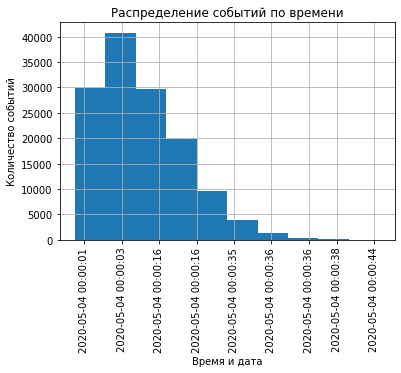

In [15]:
fig, ax = plt.subplots()
game_actions['event_datetime'].hist()
labels = ax.get_xticks().tolist()
labels = pd.to_datetime(game_actions['event_datetime'])
ax.set_xticklabels(labels, rotation=90)
plt.xlabel('Время и дата')
plt.ylabel('Количество событий')
plt.title('Распределение событий по времени')
plt.show()

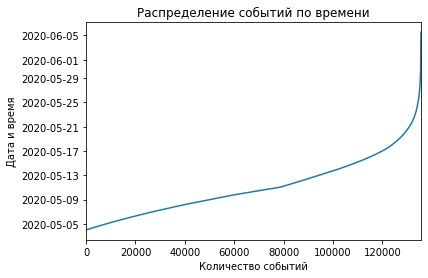

In [16]:
fig, ax = plt.subplots()
game_actions['event_datetime'].plot();
plt.xlabel('Количество событий')
plt.ylabel('Дата и время')
plt.title('Распределение событий по времени')
plt.show()

In [17]:
passed_level = game_actions.groupby('user_id')['event_datetime'].max() - game_actions.groupby('user_id')['event_datetime'].min()
passed_level.mean()

Timedelta('10 days 16:13:07.579183')

*Среднее время на прохождение уровня, неважно каким способом, занимает 10 дней*

### Найти среднее количество построек и время между ними для каждого пользователя

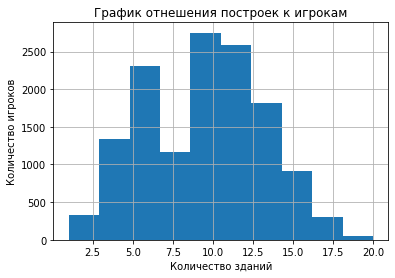

In [18]:
fig, ax = plt.subplots()
game_actions.groupby('user_id')['building_type'].count().hist()
plt.xlabel('Количество зданий')
plt.ylabel('Количество игроков')
plt.title('График отнешения построек к игрокам')
plt.show()

In [19]:
game_actions.groupby('user_id')['building_type'].count().mean()

9.425162050677667

In [20]:
cnt_buildings = game_actions.groupby(['user_id','building_type'])['event_datetime'].max() - game_actions.groupby(['user_id','building_type'])['event_datetime'].min()
cnt_buildings.mean()

Timedelta('4 days 04:10:24.427577')

*В среднем игроки делают 9 построек для прохождения уровня, затрачивая на это около 4 дней и 4 часов*

###  Разделить пользователей на основании выполненного условия игры ("строители", "победители", "остальные")


In [21]:
# выделим игроков, прошедших уровень
notbuilding = game_actions.query('event != "building"')
notbuilding_events = notbuilding.pivot_table(index='user_id', values='event',aggfunc='count').reset_index()
def game_type(row):
    event = row['event']
    if event ==1:
        return 'win'
    if event ==2:
        return 'build'
    return 'other'
notbuilding_events['gamer_type'] = notbuilding_events.apply(game_type,axis=1)
notbuilding_events

,user_id,event,gamer_type
0,001d39dc-366c-4021-9604-6a3b9ff01e25,1,win
1,003ee7e8-6356-4286-a715-62f22a18d2a1,1,win
2,004074f8-251a-4776-922c-8348dca1a2f6,1,win
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,1,win
4,0056c007-c082-43cc-bdef-afc49bca4cb9,1,win
...,...,...,...
5812,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,1,win
5813,ffe810f4-1a1f-464b-924d-6f120b0cb8df,1,win
5814,ffef4fed-164c-40e1-bde1-3980f76d0fb5,1,win
5815,fffb626c-5ab6-47c9-8113-2062a2f18494,1,win


In [22]:
# объеденим датасеты и разделим пользователей на группы
data = game_actions.merge(notbuilding_events, how='outer', left_on='user_id', right_on='user_id')
data

,event_datetime,event_x,building_type,user_id,project_type,time,month,day,hour,minute,second,event_y,gamer_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:00:01,5,4,0,0,1,NaN,NaN
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,05:20:15,5,5,5,20,15,NaN,NaN
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,19:24:02,5,5,19,24,2,NaN,NaN
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,20:59:19,5,5,20,59,19,NaN,NaN
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:52:56,5,6,0,52,56,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,23:56:39,5,13,23,56,39,NaN,NaN
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,00:23:28,5,18,0,23,28,NaN,NaN
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,23:59:52,5,10,23,59,52,NaN,NaN
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,08:11:19,5,13,8,11,19,NaN,NaN


In [23]:
others = data.query('gamer_type != "win" & gamer_type != "build"')
others

,event_datetime,event_x,building_type,user_id,project_type,time,month,day,hour,minute,second,event_y,gamer_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:00:01,5,4,0,0,1,NaN,NaN
1,2020-05-05 05:20:15,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,05:20:15,5,5,5,20,15,NaN,NaN
2,2020-05-05 19:24:02,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,19:24:02,5,5,19,24,2,NaN,NaN
3,2020-05-05 20:59:19,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,20:59:19,5,5,20,59,19,NaN,NaN
4,2020-05-06 00:52:56,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,00:52:56,5,6,0,52,56,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135634,2020-05-13 23:56:39,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,23:56:39,5,13,23,56,39,NaN,NaN
135635,2020-05-18 00:23:28,building,spaceport,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,00:23:28,5,18,0,23,28,NaN,NaN
135636,2020-05-10 23:59:52,building,assembly_shop,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,23:59:52,5,10,23,59,52,NaN,NaN
135637,2020-05-13 08:11:19,building,spaceport,bdc53e19-462a-4dc3-8b55-b4a34278af6a,NaN,08:11:19,5,13,8,11,19,NaN,NaN


In [24]:
winners = data.query('gamer_type == "win"')
winners

,event_datetime,event_x,building_type,user_id,project_type,time,month,day,hour,minute,second,event_y,gamer_type
20,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,00:00:16,5,4,0,0,16,1.0,win
21,2020-05-07 02:05:04,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,02:05:04,5,7,2,5,4,1.0,win
22,2020-05-07 04:19:08,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,04:19:08,5,7,4,19,8,1.0,win
23,2020-05-07 06:38:53,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,06:38:53,5,7,6,38,53,1.0,win
24,2020-05-08 07:14:40,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,07:14:40,5,8,7,14,40,1.0,win
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135616,2020-05-17 04:55:13,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,04:55:13,5,17,4,55,13,1.0,win
135617,2020-05-23 00:23:04,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,00:23:04,5,23,0,23,4,1.0,win
135618,2020-05-26 14:36:17,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,14:36:17,5,26,14,36,17,1.0,win
135619,2020-05-30 16:04:33,building,spaceport,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,16:04:33,5,30,16,4,33,1.0,win


In [25]:
builders = data.query('gamer_type == "build"')
builders

,event_datetime,event_x,building_type,user_id,project_type,time,month,day,hour,minute,second,event_y,gamer_type
7,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,00:00:03,5,4,0,0,3,2.0,build
8,2020-05-06 23:49:25,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,23:49:25,5,6,23,49,25,2.0,build
9,2020-05-07 03:56:30,building,spaceport,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,03:56:30,5,7,3,56,30,2.0,build
10,2020-05-07 07:58:20,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,07:58:20,5,7,7,58,20,2.0,build
11,2020-05-07 08:30:13,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,08:30:13,5,7,8,30,13,2.0,build
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135583,2020-05-28 08:45:57,building,spaceport,637a8d39-3872-4549-80cc-bebee6c88056,NaN,08:45:57,5,28,8,45,57,2.0,build
135584,2020-05-28 21:26:20,building,research_center,637a8d39-3872-4549-80cc-bebee6c88056,NaN,21:26:20,5,28,21,26,20,2.0,build
135585,2020-05-30 11:16:13,building,research_center,637a8d39-3872-4549-80cc-bebee6c88056,NaN,11:16:13,5,30,11,16,13,2.0,build
135586,2020-06-01 18:23:39,project,NaN,637a8d39-3872-4549-80cc-bebee6c88056,satellite_orbital_assembly,18:23:39,6,1,18,23,39,2.0,build


### Высчитать среднюю стоимость кликов для каждого источника трафика

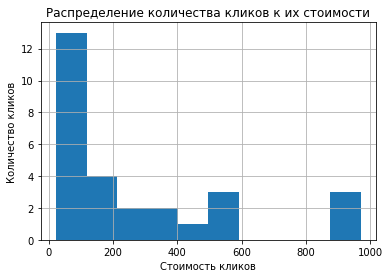

In [26]:
fig, ax = plt.subplots()
ad_costs['cost'].hist()
plt.xlabel('Стоимость кликов')
plt.ylabel('Количество кликов')
plt.title('Распределение количества кликов к их стоимости')
plt.show()

In [27]:
ad_costs['cost'].median()

160.05644335530272

*По умолчанию, показ рекламы ожидается во время выбора постройки здания. Для прохождения уровня пользователи строят около 9 зданий, между постройками проходит примерно до 10 часов ожидания.У нас 13576 игроков.*

## Создание модели монетизации

*Монетизация в играх, а тем более в жанре стратегий с free-to-play механикой нужна для ускорения процесса. Поэтому я предлагаю добавить рекламу как способ апгрейда армии, времени строительства, улучшения и защиты построек. Это затронет каждую группу игроков.*

### Посчитать количество пользователей на каждом событии. Посчитать количество пользователей на каждом типе реализованного проекта.

In [28]:
builders['user_id'].nunique()

1866

In [29]:
winners['user_id'].nunique()

3951

In [30]:
others['user_id'].nunique()

7759

### Высчитать количество  событий для показа рекламы на разных кластерах пользователей

In [31]:
others.groupby('user_id')['building_type'].count().sort_values(ascending=False)

user_id
cefc5aac-4011-4e00-becc-2634c4527713    20
a5add3ce-1ac4-4b97-aba0-f040efc4c1b0    20
4c5782eb-6f86-4fde-a2e6-695dc86fa928    20
a5f59d60-98b8-4455-ae5b-308f44715557    20
a2f85d5e-5a53-43ee-9d41-9e1def085562    20
                                        ..
70362b15-8a0b-4fb7-8a67-4454fd7098d7     1
ded24248-15c7-4037-9092-f64fcaa651e7     1
f2750d16-16dc-420f-9a61-0a9c85308086     1
dce8f331-d1ae-4d90-bc3e-0bc02929ea2e     1
f6a91a2f-b1dd-4db2-bf11-532c8f893d24     1
Name: building_type, Length: 7759, dtype: int64

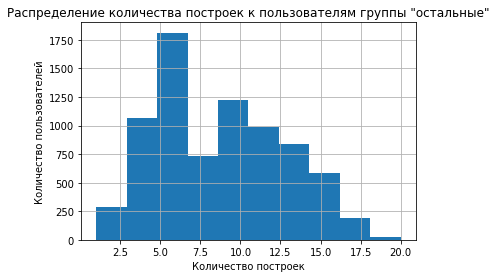

In [32]:
fig, ax = plt.subplots()
others.groupby('user_id')['building_type'].count().sort_values(ascending=False).hist()
plt.xlabel('Количество построек')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества построек к пользователям группы "остальные"')
plt.show()

In [33]:
# узнаем среднее количество построек группы
others.groupby('user_id')['building_type'].count().sort_values(ascending=False).mean()

8.657043433432143

In [34]:
winners.groupby('user_id')['building_type'].count().sort_values(ascending=False)

user_id
7ab3cfa0-efcb-4849-ba0c-ea400cce8f05    19
871e7334-271a-4fe1-a4e7-c43982a48cc0    19
615bcae8-5553-40fc-83c6-4925c6aaaff7    19
f0ef9e4d-5634-447e-9d10-40e26c067413    18
33131337-034f-4b76-8895-a89d05e6a129    18
                                        ..
ed9fce65-e7f8-407d-92ce-539772f7c080     2
5d7e74d9-71d2-4d79-97f0-99ede059e11a     2
0bdf8f24-d773-4e2b-81bf-6923de7a904f     2
875e414a-d8a8-4041-93c0-7ab12b9cd328     2
6ff3138b-b242-4ec3-b50f-8d6f999c0848     2
Name: building_type, Length: 3951, dtype: int64

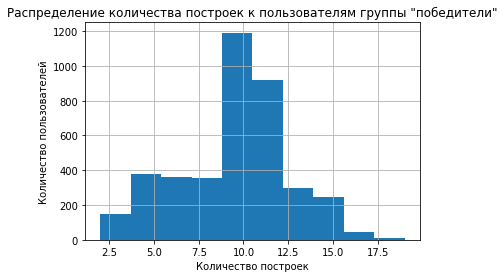

In [35]:
fig, ax = plt.subplots()
winners.groupby('user_id')['building_type'].count().sort_values(ascending=False).hist()
plt.xlabel('Количество построек')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества построек к пользователям группы "победители"')
plt.show()

In [36]:
# узнаем среднее количество построек группы
winners.groupby('user_id')['building_type'].count().sort_values(ascending=False).mean()

9.411541381928625

In [37]:
builders.groupby('user_id')['building_type'].count().sort_values(ascending=False)

user_id
d6aca06a-cd75-4cd8-b8cd-240a3c163884    20
bf542075-e3a2-4e79-82d8-3838e86d2a25    20
ff841992-d93b-462e-bc6e-18c24a514f36    20
aee12ade-c6fa-4b31-a308-bd750c8511dc    19
fa36cf08-cda1-4ee3-bee9-be16ded7071e    19
                                        ..
9613ef11-6780-402c-b6fc-919a4cf5116f    10
2a6424c6-27d4-480c-9f01-e34666ec6158    10
956a9cc8-fee4-46de-a6b1-39596990ae27    10
2a8335d7-66cb-44bc-b7cf-7d4772e634a2    10
2303f0ae-4980-4851-9a29-b7c73f8536d2    10
Name: building_type, Length: 1866, dtype: int64

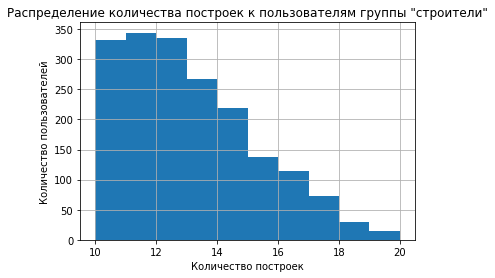

In [38]:
fig, ax = plt.subplots()
builders.groupby('user_id')['building_type'].count().sort_values(ascending=False).hist()
plt.xlabel('Количество построек')
plt.ylabel('Количество пользователей')
plt.title('Распределение количества построек к пользователям группы "строители"')
plt.show()

In [39]:
# узнаем среднее количество построек группы
builders.groupby('user_id')['building_type'].count().sort_values(ascending=False).mean()

12.64790996784566

*В зависимости от способа и темпа игры, количество построек разниться. Об этом свидетельствуют среднее значение зданий в каждой из групп.*

*7759 человек, не прошедших уровень, еще не выбрали каким способом его будут проходить. Поэтому реклама будет появлятся на время строительства постройки, а также, если они желают ускорить строительство или защитить постройку. Исходя из цифр это может быть от 1 до 20 показов во время постройки и один или два раза для улучшения этого здания.*

*Группа игроков, проходящих уровень через постройку станции также обязана строить здания от 10 до 20 штук, чтобы собрать эту самую станцию. Рекламный буст для них идентичен, но после прохода уровня можно защитить свою станцию. Сделать это можно за счет сооружений армии и тд. - ускорение данных процессов также возможно через просмотр рекламы. Всего таковых на данный момент 1866 человек, то есть 1866 просмотров рекламы для защиты станции после прохождения уровня.*

*Победители, идущие по тропе уничтожения противника, возводят от 2 до 19 сооружений, но создание армии, ресурсов и защиты своей базы стоят денег и времени. Уменьшение времени на все это сократит рекламные интеграции, ускоряющие процесс. 5817 человек/просмотров могут быть увеличены при желании пользователей уменьшить время на ожидание.*

### Узнаем количество оставшихся пользователей после показа рекламы

*Многие игроки не терпят рекламу или посчитают ее навязчивой. Возьмём 10% возможного оттока после ее показа*

In [40]:
builders['user_id'].nunique()-(builders['user_id'].nunique() / 100 * 10)

1679.4

In [41]:
winners['user_id'].nunique()-(winners['user_id'].nunique() / 100 * 10)

3555.9

In [42]:
others['user_id'].nunique()-(others['user_id'].nunique() / 100 * 10)

6983.1

### Расчитать стоимость показа рекламы для разных источников

*Необходимо найти САС - сумму привлечения пользователя*

In [43]:
costs = user_source.merge(ad_costs,how='inner',left_on='source', right_on='source')
costs['cost'] = costs['cost'].drop_duplicates()
costs

,user_id,source,day,cost
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-03,935.882786
1,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-04,548.354480
2,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-05,260.185754
3,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-06,177.982200
4,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads,2020-05-07,111.766796
...,...,...,...,...
95027,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-05,NaN
95028,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-06,NaN
95029,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-07,NaN
95030,ffff194a-56b7-4c12-860d-3485242ae7f5,instagram_new_adverts,2020-05-08,NaN


In [44]:
CAC = costs.groupby('source')['cost'].sum() / costs.groupby('source')['user_id'].nunique()
CAC

source
facebook_ads               0.785365
instagram_new_adverts      0.645785
yandex_direct              0.463590
youtube_channel_reklama    0.397662
dtype: float64

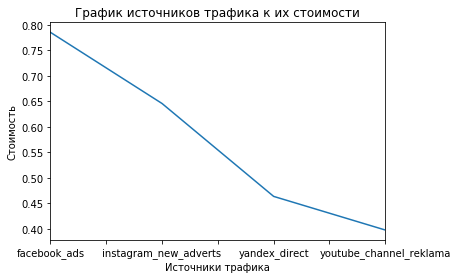

In [45]:
fig, ax = plt.subplots()
CAC.plot();
plt.xlabel('Источники трафика')
plt.ylabel('Стоимость')
plt.title('График источников трафика к их стоимости')
plt.show()

*Стоимость привлечения одного пользователя с помощью рекламы в каналах на YouTube обходятся в два раза дешевле остальных источников.*

In [46]:
CAC/20

source
facebook_ads               0.039268
instagram_new_adverts      0.032289
yandex_direct              0.023179
youtube_channel_reklama    0.019883
dtype: float64

*По-умолчанию, минимальный порог рекламы для построек на каждой группе может быть 20 раз. На это количество мы и делим САС. Стоимость показа одной рекламы не должна привышать этих значений для выхода в ноль*

##  Выдвижение и проверка гипотез

### Проверить гипотезу различия времени прохождения уровня между пользователями, которые заканчивают уровень через реализацию проекта, и пользователями, которые заканчивают уровень победой над другим игроком

Н_0: Время прохождения уровня строителей = Время прохождения уровня победителей

Н_1: Время прохождения уровня строителей != Время прохождения уровня победителей

In [47]:
#найдем время первой постройки и окончания уровня
lvltime_builders = builders.groupby('user_id')[['event_datetime', 'event_x']].agg(['min','max'])
lvltime_builders

event_datetime                      \
                                                     min                 max   
user_id                                                                        
006380d6-67a6-45de-ab1e-6eb54ad8dbe8 2020-05-04 16:43:39 2020-05-16 11:22:33   
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82 2020-05-08 21:57:44 2020-05-24 19:05:12   
00c2b9f2-2615-439c-aed0-6974e4c6c1c1 2020-05-07 10:26:09 2020-05-27 11:38:47   
00de2809-403e-4476-a2f7-ca1b11700190 2020-05-04 07:48:50 2020-05-18 09:34:10   
00e83261-5fd4-4939-9616-802b5a0202c6 2020-05-05 15:49:57 2020-05-20 09:35:04   
...                                                  ...                 ...   
ff50f63a-c4b3-494e-8bf9-3f19dbfc513e 2020-05-04 09:09:43 2020-05-23 16:59:43   
ff60fcd1-4329-494e-b82d-461fbdf5b5eb 2020-05-05 01:03:38 2020-05-13 00:02:51   
ff83bdd8-f49a-49fd-8aad-9fa1fb30d516 2020-05-04 06:39:58 2020-05-18 22:50:51   
ff841992-d93b-462e-bc6e-18c24a514f36 2020-05-05 06:05:51 2020-05-16 00:28:59   
ffff69cc-fec1-4fd3-9f98-93be1112a6b8 2020-05-08 06:57:30 2020-05-25 14:05:51   

                                       event_x           
                                           min      max  
user_id                                                  
006380d6-67a6-45de-ab1e-6eb54ad8dbe8  building  project  
00be7371-fa79-4fbd-b8e7-8ba32e3f8f82  building  project  
00c2b9f2-2615-439c-aed0-6974e4c6c1c1  building  project  
00de2809-403e-4476-a2f7-ca1b11700190  building  project  
00e83261-5fd4-4939-9616-802b5a0202c6  building  project  
...                                        ...      ...  
ff50f63a-c4b3-494e-8bf9-3f19dbfc513e  building  project  
ff60fcd1-4329-494e-b82d-461fbdf5b5eb  building  project  
ff83bdd8-f49a-49fd-8aad-9fa1fb30d516  building  project  
ff841992-d93b-462e-bc6e-18c24a514f36  building  project  
ffff69cc-fec1-4fd3-9f98-93be1112a6b8  building  project  

[1866 rows x 4 columns]

In [48]:
# избавимся от мультииндекса и переименуем столбцы
lvltime_builders.columns = lvltime_builders.columns.droplevel(0)
lvltime_builders.reset_index(inplace=True)
lvltime_builders.columns = ['user_id', 'start', 'end', 'first_event', 'last_event']
lvltime_builders

,user_id,start,end,first_event,last_event
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,2020-05-04 16:43:39,2020-05-16 11:22:33,building,project
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,2020-05-08 21:57:44,2020-05-24 19:05:12,building,project
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,2020-05-07 10:26:09,2020-05-27 11:38:47,building,project
3,00de2809-403e-4476-a2f7-ca1b11700190,2020-05-04 07:48:50,2020-05-18 09:34:10,building,project
4,00e83261-5fd4-4939-9616-802b5a0202c6,2020-05-05 15:49:57,2020-05-20 09:35:04,building,project
...,...,...,...,...,...
1861,ff50f63a-c4b3-494e-8bf9-3f19dbfc513e,2020-05-04 09:09:43,2020-05-23 16:59:43,building,project
1862,ff60fcd1-4329-494e-b82d-461fbdf5b5eb,2020-05-05 01:03:38,2020-05-13 00:02:51,building,project
1863,ff83bdd8-f49a-49fd-8aad-9fa1fb30d516,2020-05-04 06:39:58,2020-05-18 22:50:51,building,project
1864,ff841992-d93b-462e-bc6e-18c24a514f36,2020-05-05 06:05:51,2020-05-16 00:28:59,building,project


In [49]:
# найдем время прохождения уровня
lvltime_builders['lvltime'] = (lvltime_builders['end'] - lvltime_builders['start']).astype('timedelta64[m]').astype(int)
lvltime_builders

,user_id,start,end,first_event,last_event,lvltime
0,006380d6-67a6-45de-ab1e-6eb54ad8dbe8,2020-05-04 16:43:39,2020-05-16 11:22:33,building,project,16958
1,00be7371-fa79-4fbd-b8e7-8ba32e3f8f82,2020-05-08 21:57:44,2020-05-24 19:05:12,building,project,22867
2,00c2b9f2-2615-439c-aed0-6974e4c6c1c1,2020-05-07 10:26:09,2020-05-27 11:38:47,building,project,28872
3,00de2809-403e-4476-a2f7-ca1b11700190,2020-05-04 07:48:50,2020-05-18 09:34:10,building,project,20265
4,00e83261-5fd4-4939-9616-802b5a0202c6,2020-05-05 15:49:57,2020-05-20 09:35:04,building,project,21225
...,...,...,...,...,...,...
1861,ff50f63a-c4b3-494e-8bf9-3f19dbfc513e,2020-05-04 09:09:43,2020-05-23 16:59:43,building,project,27830
1862,ff60fcd1-4329-494e-b82d-461fbdf5b5eb,2020-05-05 01:03:38,2020-05-13 00:02:51,building,project,11459
1863,ff83bdd8-f49a-49fd-8aad-9fa1fb30d516,2020-05-04 06:39:58,2020-05-18 22:50:51,building,project,21130
1864,ff841992-d93b-462e-bc6e-18c24a514f36,2020-05-05 06:05:51,2020-05-16 00:28:59,building,project,15503


In [50]:
lvltime_winners = winners.groupby('user_id')[['event_datetime', 'event_x']].agg(['min','max'])
lvltime_winners

event_datetime                      \
                                                     min                 max   
user_id                                                                        
001d39dc-366c-4021-9604-6a3b9ff01e25 2020-05-05 21:02:05 2020-05-12 07:40:47   
003ee7e8-6356-4286-a715-62f22a18d2a1 2020-05-05 08:31:04 2020-05-17 21:47:49   
004074f8-251a-4776-922c-8348dca1a2f6 2020-05-04 01:07:35 2020-05-16 19:57:40   
00464e5e-28ed-4be6-bf44-517ef7b3937b 2020-05-04 08:35:29 2020-05-15 16:02:01   
0056c007-c082-43cc-bdef-afc49bca4cb9 2020-05-10 11:49:47 2020-05-16 13:48:39   
...                                                  ...                 ...   
ffc6f4fa-3476-47af-85cb-e2ee0551110a 2020-05-04 03:59:12 2020-05-15 12:18:42   
ffd002f3-3545-423e-8dba-0c6a2d48a3aa 2020-05-06 06:34:18 2020-05-19 04:03:24   
ffe810f4-1a1f-464b-924d-6f120b0cb8df 2020-05-04 17:46:05 2020-05-18 02:03:36   
ffef4fed-164c-40e1-bde1-3980f76d0fb5 2020-05-04 01:58:59 2020-05-11 22:15:54   
fffb626c-5ab6-47c9-8113-2062a2f18494 2020-05-04 02:05:09 2020-05-12 13:01:52   

                                       event_x                    
                                           min               max  
user_id                                                           
001d39dc-366c-4021-9604-6a3b9ff01e25  building  finished_stage_1  
003ee7e8-6356-4286-a715-62f22a18d2a1  building  finished_stage_1  
004074f8-251a-4776-922c-8348dca1a2f6  building  finished_stage_1  
00464e5e-28ed-4be6-bf44-517ef7b3937b  building  finished_stage_1  
0056c007-c082-43cc-bdef-afc49bca4cb9  building  finished_stage_1  
...                                        ...               ...  
ffc6f4fa-3476-47af-85cb-e2ee0551110a  building  finished_stage_1  
ffd002f3-3545-423e-8dba-0c6a2d48a3aa  building  finished_stage_1  
ffe810f4-1a1f-464b-924d-6f120b0cb8df  building  finished_stage_1  
ffef4fed-164c-40e1-bde1-3980f76d0fb5  building  finished_stage_1  
fffb626c-5ab6-47c9-8113-2062a2f18494  building  finished_stage_1  

[3951 rows x 4 columns]

In [51]:
lvltime_winners.columns = lvltime_winners.columns.droplevel(0)
lvltime_winners.reset_index(inplace=True)
lvltime_winners.columns = ['user_id', 'start', 'end', 'first_event', 'last_event']
lvltime_winners

,user_id,start,end,first_event,last_event
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,building,finished_stage_1
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,building,finished_stage_1
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,building,finished_stage_1
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,building,finished_stage_1
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,building,finished_stage_1
...,...,...,...,...,...
3946,ffc6f4fa-3476-47af-85cb-e2ee0551110a,2020-05-04 03:59:12,2020-05-15 12:18:42,building,finished_stage_1
3947,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06 06:34:18,2020-05-19 04:03:24,building,finished_stage_1
3948,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04 17:46:05,2020-05-18 02:03:36,building,finished_stage_1
3949,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,2020-05-11 22:15:54,building,finished_stage_1


In [52]:
lvltime_winners['lvltime'] = (lvltime_winners['end'] - lvltime_winners['start']).astype('timedelta64[m]').astype(int)
lvltime_winners

,user_id,start,end,first_event,last_event,lvltime
0,001d39dc-366c-4021-9604-6a3b9ff01e25,2020-05-05 21:02:05,2020-05-12 07:40:47,building,finished_stage_1,9278
1,003ee7e8-6356-4286-a715-62f22a18d2a1,2020-05-05 08:31:04,2020-05-17 21:47:49,building,finished_stage_1,18076
2,004074f8-251a-4776-922c-8348dca1a2f6,2020-05-04 01:07:35,2020-05-16 19:57:40,building,finished_stage_1,18410
3,00464e5e-28ed-4be6-bf44-517ef7b3937b,2020-05-04 08:35:29,2020-05-15 16:02:01,building,finished_stage_1,16286
4,0056c007-c082-43cc-bdef-afc49bca4cb9,2020-05-10 11:49:47,2020-05-16 13:48:39,building,finished_stage_1,8758
...,...,...,...,...,...,...
3946,ffc6f4fa-3476-47af-85cb-e2ee0551110a,2020-05-04 03:59:12,2020-05-15 12:18:42,building,finished_stage_1,16339
3947,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,2020-05-06 06:34:18,2020-05-19 04:03:24,building,finished_stage_1,18569
3948,ffe810f4-1a1f-464b-924d-6f120b0cb8df,2020-05-04 17:46:05,2020-05-18 02:03:36,building,finished_stage_1,19217
3949,ffef4fed-164c-40e1-bde1-3980f76d0fb5,2020-05-04 01:58:59,2020-05-11 22:15:54,building,finished_stage_1,11296


In [53]:
alpha = 0.05 

results = st.ttest_ind(lvltime_winners['lvltime'],lvltime_builders['lvltime'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  7.261151385117754e-98
Отвергаем нулевую гипотезу


### Проверить гипотезу различия стоимости кликов в Facebook и остальных источников

Н_0: Стоимость кликов в Facebook = Стоимость кликов в остальных источниках

Н_1: Стоимость кликов в Facebook != Стоимость кликов в остальных источниках

In [54]:
alpha = 0.05 

results = st.ttest_ind(costs.dropna().query('source == "facebook_ads"')['cost'], 
                       costs.dropna().query('source != "facebook_ads"')['cost'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.7223387745070895
Не получилось отвергнуть нулевую гипотезу


*После проведенной работы выяснили, что среднее время на прохождение уровня, неважно каким способом, занимает 10 дней. В среднем игроки делают 9 построек для прохождения уровня, затрачивая на это около 4 дней и 4 часов. В датасете 13576 игроков, из которых 1866 человек заканчивают уровень через выполнение проекта, 3951 победой над противником и 7759 еще не выбрали стратегию игры. Основная монетизация осуществляется путем показа рекламы во время выбора постройки здания, создание армии и тд. Дополнительная с помощью реварда игроков - для защиты здания, армии или проекта, уменьшения скорости стройки - будет показана реклама. Она ненавязчивая и многим игрокам даже полезна. Минимальный порог рекламы 20 шт со стоимостью не выше 0.04у.е.*